In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense


#copypasted -> for gpu usage
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib 

Using TensorFlow backend.


In [2]:
# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Amount of GPUs available: 4


In [3]:
#Get data and make it usable
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()
df['gasPower'] = df['gasPower']*10 #This factor is used for getting a higher mean squared error and make it easier for working
df['T-1'] = df['T'].shift(1)
df_d = df.resample('1D').mean() #Resampling to a day
df_d = df_d.dropna()

In [4]:
#Add dummies!
df_d['hour'] = df_d.index.hour #create dummy variable (hour)
df_d['dayofweek'] = df_d.index.dayofweek #Create dummy variable (day of the week)
columns_to_cat = ['hour', 'dayofweek']
df_d[columns_to_cat] = df_d[columns_to_cat].astype('category') # change datetypes->category
df_d = pd.get_dummies(df_d, columns=columns_to_cat)


In [5]:
#Split, originally thought about using the train_test_split function but it seems to give some errors
X = df_d[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]
y = df_d[['gasPower']]
#labelencoder_y_1 = LabelEncoder()
#y = labelencoder_y_1.fit_transform(y)
y = np.array(y)

test_size=0.3
split_index = int(df_d.shape[0]*test_size)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

#scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train) #Normalization! :D

[[2.56245931]
 [4.85712687]
 [2.76830037]
 [0.17166138]
 [5.03000895]
 [1.31581624]
 [5.04040527]
 [2.52451579]
 [2.4991862 ]
 [3.0353597 ]
 [2.19167074]
 [2.0673116 ]
 [2.62519836]
 [2.61296123]
 [2.687079  ]
 [1.5579228 ]
 [1.85116544]
 [1.92430551]
 [1.46015805]
 [1.49257421]
 [1.77267135]
 [1.00274416]
 [0.98946077]
 [1.34910676]
 [1.67839251]
 [1.54518026]
 [1.72216342]
 [1.5392286 ]
 [1.72977662]
 [1.47004588]
 [1.40551249]
 [1.52474192]
 [1.44855394]
 [1.0955627 ]
 [0.88757901]
 [0.92034882]
 [0.53990342]
 [0.47714175]
 [0.92406068]
 [0.80240321]
 [0.86580925]
 [0.67944216]
 [1.38938408]
 [0.84127836]
 [0.73234608]
 [0.5457193 ]
 [0.79604198]
 [1.23865652]
 [0.95795132]
 [1.40269548]
 [1.03364315]
 [1.00792175]
 [1.17352637]
 [1.51331538]
 [1.40762816]
 [1.26738736]
 [1.05204343]
 [1.04386119]
 [1.26140013]
 [1.15904216]
 [1.27742484]
 [1.34719899]
 [1.36207257]
 [1.16765204]
 [1.26781472]
 [0.86517437]
 [0.69285689]
 [1.1915801 ]
 [1.1449973 ]
 [0.73656464]
 [1.27829357]
 [0.71

In [6]:
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)
#y_train = scalery.transform(y_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


In [7]:
model = Sequential()

#first layer with the input data
model.add(Dense(output_dim =16, init = 'uniform', activation = 'relu', input_dim = 9))
#second layer 
model.add(Dense(output_dim = 16, init = 'uniform', activation = 'relu'))
#output layer
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=16, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  


In [8]:
model = multi_gpu_model(model, gpus=num_gpu)

In [9]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [10]:
y_train = (y_train-min(y_train))/(max(y_train)-min(y_train))

model.fit(X_train, y_train, batch_size = 10,epochs = 100,verbose=0)

In [11]:
y_predict = model.predict(X_test)
x_datetime = df_d.index[len(X_train):]
y_test = (y_test-min(y_test))/(max(y_test)-min(y_test))
#y_predict = scalery.inverse_transform(y_predict)

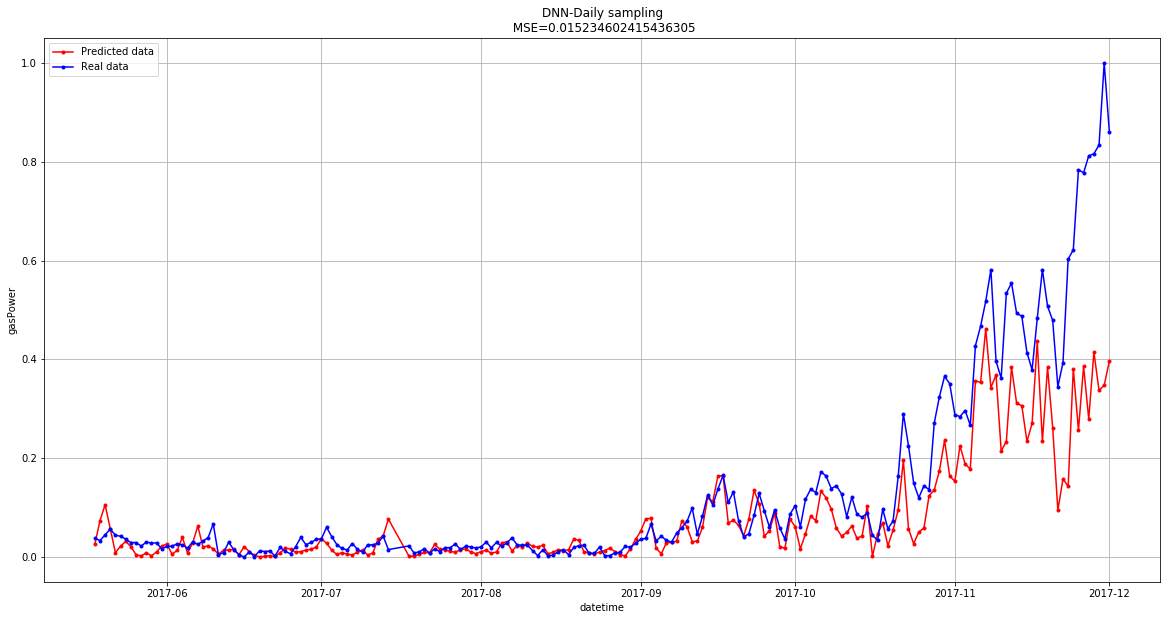

In [12]:
plt.figure(figsize=(20,10))

#This will plot the prediction 
plt.title('DNN-Daily sampling\n MSE='+str(mean_squared_error(y_test,y_predict)))
plt.plot(x_datetime,y_predict,'.-',color='r',label='Predicted data')
plt.xlabel('datetime')
plt.ylabel('gasPower')
plt.grid(True)

#This will plot the real data
plt.plot(x_datetime,y_test,'.-',color='b',label='Real data')
plt.xlabel('datetime')
plt.ylabel('gasPower')
plt.legend()
plt.show()